Files already downloaded and verified
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 1, 'type': 'max'} -> Accuracy: 0.9000
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 1, 'type': 'avg'} -> Accuracy: 0.8700
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 2, 'type': 'max'} -> Accuracy: 0.5800
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 2, 'stride': 2, 'type': 'avg'} -> Accuracy: 0.5800
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 1, 'type': 'max'} -> Accuracy: 0.8200
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 1, 'type': 'avg'} -> Accuracy: 0.7300
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 2, 'type': 'max'} -> Accuracy: 0.5300
Params: {'kernel_size': 3, 'stride': 1, 'padding': 0} | {'size': 3, 'stride': 2, 'type': 'avg'} -> Accuracy: 0.5400
Params: {'kernel_size': 3, 'stride

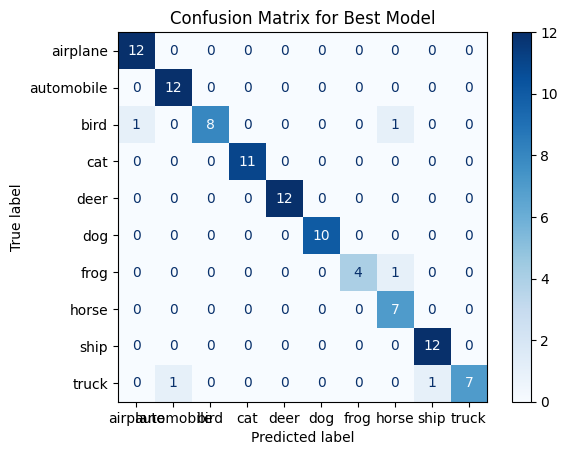

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Parameters
BATCH_SIZE = 8
NUM_EPOCHS = 8
SUBSET_SIZE = 100  # Use only a small part of CIFAR-10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10 Dataset (10 classes: airplane, automobile, bird, etc.)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.CIFAR10(root='/content/drive/MyDrive/CV_Project/latest_dataset/', train=True, download=True, transform=transform)
subset_indices = np.random.choice(len(dataset), SUBSET_SIZE, replace=False)
subset_data = Subset(dataset, subset_indices)
train_loader = DataLoader(subset_data, batch_size=BATCH_SIZE, shuffle=True)

# Define possible hyperparameters for brute-force search
kernel_sizes = [3, 5]
strides = [1, 2]
paddings = [0, 1]
pooling_sizes = [2, 3]
pooling_strides = [1, 2]
pooling_types = ['max', 'avg']

# Helper function to create pooling layers
def create_pooling_layer(pool_type, kernel_size, stride):
    if pool_type == 'max':
        return nn.MaxPool2d(kernel_size=kernel_size, stride=stride)
    elif pool_type == 'avg':
        return nn.AvgPool2d(kernel_size=kernel_size, stride=stride)

# Squeeze-and-Excitation (SE) Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        se = F.adaptive_avg_pool2d(x, 1).view(batch_size, channels)
        se = F.relu(self.fc1(se))
        se = torch.sigmoid(self.fc2(se)).view(batch_size, channels, 1, 1)
        return x * se

# CNN Model with dynamic configuration and SE Block
class DynamicCNN(nn.Module):
    def __init__(self, conv_params, pool_params):
        super(DynamicCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,
                               kernel_size=conv_params['kernel_size'],
                               stride=conv_params['stride'],
                               padding=conv_params['padding'])
        self.se1 = SEBlock(16)  # Add SE block after first convolution
        self.pool1 = create_pooling_layer(pool_params['type'], pool_params['size'], pool_params['stride'])
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.se2 = SEBlock(32)  # Add SE block after second convolution
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(self._get_flattened_size(), 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for CIFAR-10

    def _get_flattened_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 32, 32).to(device)  # CIFAR-10 image size
            x = F.relu(self.conv1(x))
            x = self.se1(x)  # Apply SE block
            x = self.pool1(x)
            x = F.relu(self.conv2(x))
            x = self.se2(x)  # Apply SE block
            x = self.pool2(x)
            return x.view(1, -1).size(1)  # Flatten and return size

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.se1(x)  # Apply SE block
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.se2(x)  # Apply SE block
        x = self.pool2(x)
        x = x.view(-1, self._get_flattened_size())  # Use dynamically calculated flattened size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to evaluate a configuration
def evaluate_configuration(conv_params, pool_params):
    model = DynamicCNN(conv_params, pool_params).to(device)  # Ensure model is on device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model for a few epochs
    model.train()
    for epoch in range(NUM_EPOCHS):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate the model on the training data
    model.eval()
    correct = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = correct / SUBSET_SIZE
    return accuracy, all_labels, all_preds, model

# Brute-force search over parameter combinations
best_accuracy = 0
best_params = None
best_model = None

for conv_kernel, conv_stride, conv_padding, pool_size, pool_stride, pool_type in itertools.product(
    kernel_sizes, strides, paddings, pooling_sizes, pooling_strides, pooling_types):

    conv_params = {'kernel_size': conv_kernel, 'stride': conv_stride, 'padding': conv_padding}
    pool_params = {'size': pool_size, 'stride': pool_stride, 'type': pool_type}

    accuracy, all_labels, all_preds, model = evaluate_configuration(conv_params, pool_params)
    print(f"Params: {conv_params} | {pool_params} -> Accuracy: {accuracy:.4f}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = (conv_params, pool_params)
        best_model = model
        best_labels, best_preds = all_labels, all_preds

print(f"\nBest Configuration: {best_params} with Accuracy: {best_accuracy:.4f}")

# Final evaluation metrics
accuracy = accuracy_score(best_labels, best_preds)
precision = precision_score(best_labels, best_preds, average='macro')
recall = recall_score(best_labels, best_preds, average='macro')
f1 = f1_score(best_labels, best_preds, average='macro')

# Print the final results
print("\nFinal Evaluation Metrics for the Best Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(best_labels, best_preds)
ConfusionMatrixDisplay(conf_matrix, display_labels=dataset.classes).plot(cmap='Blues')
plt.title("Confusion Matrix for Best Model")
plt.show()
